# INTRODUCCIÓN A FloPy

El paquete FloPy consta de un conjunto de scripts de Python para ejecutar MODFLOW, MT3D, SEAWAT y otros programas de aguas subterráneas relacionados con MODFLOW. 
El proyecto FloPy comenzó en 2009 y ha crecido hasta convertirse en un conjunto bastante completo de scripts con una base de usuarios en crecimiento. Tiene la capacidad de especificar condiciones de contorno que varían en el tiempo y que se especifican con una secuencia de valores de capa, fila y columna, como los paquetes WEL y GHB. Permite implementar una variedad de formas flexibles para especificar condiciones de contorno. Y lo mejor, es un proyecto de código abierto.
La información del paquete se encuentra en:
https://flopy.readthedocs.io/en/3.3.2/source/flopy.utils.reference.html

Para ejecutar los modelos, es necesario especificar la ruta donde se encuentran los ejecutables. Para esto, cree una carpeta y cargue los archivos correspondientes. Cree también una carpeta donde almacenará los resultados (Results). Deberá visualizar lo siguiente:


![1](1.png)

# Instalar paquetes

In [ ]:
pip install flopy

## Cargar paquetes

In [1]:
import os
#os.chdir(os.path.join(os.path.dirname(__file__)))
print(os.getcwd())
import flopy
#import plot_basic as pltb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Equipo\FloPy_1


# Configuración del modelo
Aquí se indican las rutas donde se encuentran los ejecutables, los archivos base y dónde se generarán los resultados de las simulaciones.

In [2]:
# Assigns the name and creates the object model MODFLOW
modelname = 'ModeloD'
exe_name='../Exe/mf2005.exe'
model_ws='Results'
#mf1 = flopy.modflow.Modflow(modelname, exe_name="Exe/mf2005.exe", model_ws=model_ws)
mf1 = flopy.modflow.Modflow(modelname, exe_name="Exe/MODFLOW-NWT_64.exe",model_ws=model_ws)


# Configuración de la geometría del modelo

In [3]:
h1 = 1000
h2 = 1000
Nlay = 1
Rows = 50 #Rows
Columns = 9 #Columns
H = 50.0
k = 50.0
delr = delc = 500
bot = 980
q = -20000
rch=0.0001
#funcion top
a = 0.04 


In [4]:
# Estimación de la topografía a partir de una posición con una ecuación cuadrática
top = np.zeros((Nlay, Rows, Columns))

for z in range(0,Nlay):
    for y in range (0,Rows):
        for x in range (0,Columns):                      
            f= (-4/125) * y**2 + (8/5) * y + 1000  # Función cuadrática para el terreno
            top[z,y,x]= f
            # print(x,f)
top[0,0]=1000-5
top[-1,-1]=1000

## Discretización del modelo

In [5]:
# https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html
dis = flopy.modflow.ModflowDis(mf1,Nlay,Rows,Columns,delr=delr,delc=delc,top=top,botm=bot,itmuni=4,lenuni=2)      

[<AxesSubplot:title={'center':' model_top'}>,
 <AxesSubplot:title={'center':'botm layer 1'}>]

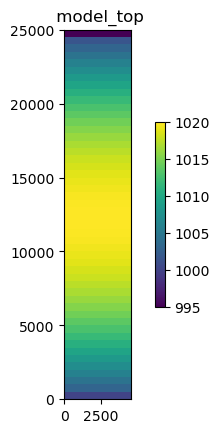

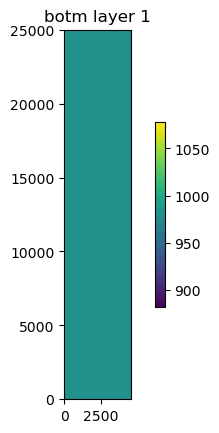

In [6]:
dis.plot()

## Condiciones de frontera

In [7]:
iboundData = np.ones((Nlay, Rows, Columns))
# iboundData[0,0]=-1
iboundData[-1,-1]=-1

#print(iboundData)

In [8]:
#https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html
bas = flopy.modflow.ModflowBas(mf1,ibound=iboundData,strt=top)

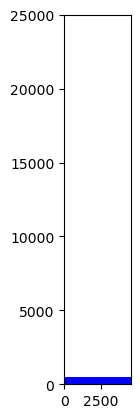

In [9]:
mapview = flopy.plot.PlotMapView(model=mf1)
quadmesh = mapview.plot_ibound()

In [10]:
mf1.bas6.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



[<AxesSubplot:title={'center':'ibound layer 1'}>,
 <AxesSubplot:title={'center':'strt layer 1'}>]

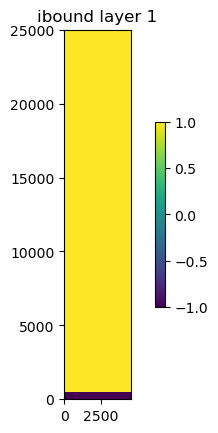

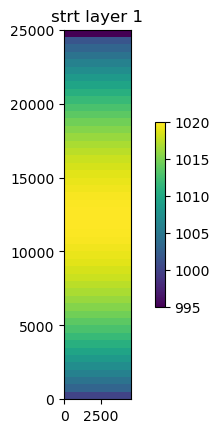

In [11]:
bas.plot()

## Asignar propiedades a los layers

In [12]:
#https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
upw = flopy.modflow.ModflowLpf(mf1, laytyp = [0], 
                               hk = k,ipakcb=53,
                                # chani= [0,0,0,0,0], #If CHANI is less than or equal to 0, then variable HANI defines horizontal anisotropy
                                # layvka=[1,1,1,1,1], # the ratio of horizontal to vertical hydraulic conductivity.
                                # vka=Vk
                               )
#pltb.plotcrossecction(model=mf1, column=True, number=4, k=k)


## Asignación de la recarga

In [13]:
#Se construye el arreglo que contiene la recarga, es decir, una matriz de unos multipicada por el valor de la recraga.
rchData = np.ones((Rows, Columns))*rch
rch_data = {0: rchData}

#nrchop = 1: Recharge to top grid layer only 2: Recharge to layer defined in irch 3: Recharge to highest active cell (default is 3)
rch = flopy.modflow.ModflowRch(mf1, nrchop=3, rech =rch_data)


## Asignación de río

El valor de conductancia (cond) se puede calcular a partir de la longitud de un tramo (Ln) a través de una celda, el ancho del río (Wn) en la celda, el espesor del lecho del río (Mn) y la conductividad hidráulica vertical del material del lecho del río (Kn) utilizando la siguiente fórmula:

$ cond= \frac{Kn  Ln  Wn}{Mn}$


![2](2.png)

In [14]:
#https://flopy.readthedocs.io/en/latest/source/flopy.modflow.mfriv.html
Kn = [5] 
Mn= 1
resolution=5
Ln= int(resolution)
Wn= 5 #could be changed if we created measure of river

cond =  5*Ln*Wn/Mn
rbot= 995
listd = []

# for i in range(0,Nlay):
    # for q in range(0,Rows):
for a in range(0,Columns):
    listd.append([0,0,a,1000,cond,rbot]) # [lay, row, col, stage, cond, rbot],


rivDrn = {0:listd}
riv = flopy.modflow.ModflowRiv(mf1, stress_period_data=rivDrn,ipakcb=53)

In [15]:
#https://flopy.readthedocs.io/en/3.4.3/source/flopy.modflow.mfpcg.html
pcg = flopy.modflow.mfpcg.ModflowPcg(mf1, mxiter=100, iter1=60, hclose=1e-03, rclose=1e-03, relax=1.0) 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget','save drawdown']}
oc = flopy.modflow.ModflowOc(mf1, stress_period_data=spd, compact=False)
mf1.write_input()
# mf1.check(level = 2)
success, buff = mf1.run_model()

FloPy is using the following executable to run the model: ..\Exe\MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: ModeloD.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/30 15:45:56

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/30 15:45:56
 Elapsed run time:  0.022 Seconds

  Normal termination of simulation


In [16]:
#%%Save and print Bugdet
from flopy.utils import MfListBudget

ml_list = MfListBudget('Results/'+modelname+'.list')
budget= ml_list.get_dataframes()
print(budget[0].T/86400) # day

                     1970-01-02
STORAGE_IN             0.000000
CONSTANT_HEAD_IN       0.000000
RIVER_LEAKAGE_IN       0.000000
RECHARGE_IN            0.127604
TOTAL_IN               0.127604
STORAGE_OUT            0.000000
CONSTANT_HEAD_OUT      0.076847
RIVER_LEAKAGE_OUT      0.050757
RECHARGE_OUT           0.000000
TOTAL_OUT              0.127604
IN-OUT                 0.000000
PERCENT_DISCREPANCY    0.000000


# Cargas hidráulicas

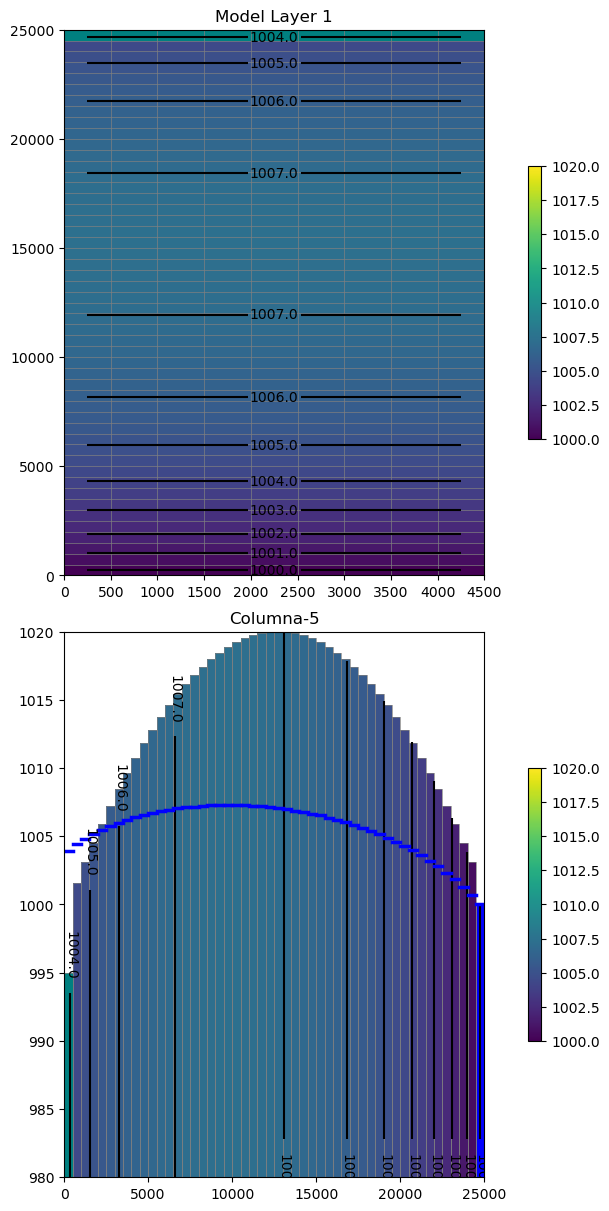

In [17]:
headfile = f"{modelname}.hds"

fname = os.path.join(model_ws, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data(kstpkper=(0, 0))
vmin, vmax = 1000.0, 1020.0
contour_intervals = np.arange(1000, 1020, 1)



fig, axes = plt.subplots(2, 1, figsize=(6, 12), constrained_layout=True)
# first subplot
ax = axes[0]
ax.set_title("Model Layer 1")
modelmap = flopy.plot.PlotMapView(model=mf1, ax=ax)
quadmesh = modelmap.plot_ibound()
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("RIV")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)


# second subplot
NoColumna=5

ax = axes[1]
ax.set_title("Columna-" + str(NoColumna))
modelmap = flopy.plot.PlotCrossSection(
    model=mf1,
    ax=ax,
    line={"Column": NoColumna},
)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_bc("RIV")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
wt = modelmap.plot_surface(h, color="blue", lw=2.5)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax);